# Predict the time of the next eathquake

In [1]:
import Utils
import pydoc
from Utils import DataSet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Name of current file

In [2]:
current_file = 'time-disc'
setting = 10

# Settings, formatData:

| **config:** (input data)                                                                                |
|---------------------------------------------------------------------------------------------------------|
| **0: Includes (9 features)** | **1: Includes (9 + 4 = 13 features)** | **2: Includes (9 + 4 + 9 = 22 features)** |
| - Time                     | - Latitude                          | - Eigenvalue, 3 values               |
| - Magnitude                | - Longitude                         | - Plunge, 3 values                   |
| - Moment Tensor Exponent   | - Depth                             | - Azimuth, 3 values                  |
| - Moment Tensor, 6 values  | - Scalar moment                     |                                      |


## Variable input

In [3]:
call = []
call.append([])
call.append([EarlyStopping(patience=2)])

In [4]:
act, day, epo, cal, ear = Utils.experiment_settings(setting)

activation = act
maxdays = day
epochs = epo
callbacks = call[cal]
early = ear

## Constant in experiments

In [5]:
scale = 1
shape = 1
categories_in = 10
categories_out = 10
mags = [5.5, 6.5]

## Get data from database, and format predictors and target

In [6]:
ds = DataSet('1972/01/01', '2019/01/01', maxdays=maxdays)

Created new DataSet containing 2157 seismic events, ( will be using 2155 )
Radius: 1000  km
Center: 46 °, 151 °
From: 1972/01/01 
To: 2019/01/01


## Predictors

In [7]:
n_predictors = 0
predict_txt = []
for k in range(3):
    exec(f'predictors{n_predictors} = ds.formatData(config={k}, norm=scale, shape=shape)')
    exec(f'predict_txt.append(\"Data config {k}: predictors{n_predictors} - input values \
between -1 and 1\")')
    print(predict_txt[n_predictors])
    n_predictors += 1
    exec(f'predictors{n_predictors} = ds.formatDataDiscrete(categories=categories_in, \
config={k}, norm=scale, shape=shape)')
    exec(f'predict_txt.append(\"Data config {k}: predictors{n_predictors} - discrete input \
values ({categories_in} categories)\")')
    print(predict_txt[n_predictors])
    n_predictors += 1

Data config 0: predictors0 - input values between -1 and 1
Data config 0: predictors1 - discrete input values (10 categories)
Data config 1: predictors2 - input values between -1 and 1
Data config 1: predictors3 - discrete input values (10 categories)
Data config 2: predictors4 - input values between -1 and 1
Data config 2: predictors5 - discrete input values (10 categories)


In [8]:
pred_shape = []

for k in range(n_predictors):
    exec(f'pred_shape.append(predictors{k}.shape[2])')
print("Feature size of predictors:", pred_shape)

Feature size of predictors: [9, 90, 13, 130, 22, 220]


## Targets

In [9]:
n_targets = 0
target_txt = []
for i in range(len(mags)):
    exec(f'target_txt.append(\"targets{n_targets} - Earthquake with magnitude above {mags[i]}. \
Time of event divided in {categories_out} categories.\")')
    print(target_txt[n_targets])
    exec(f'targets{n_targets} = ds.gt_time_disc(mags[i], categories=categories_out)')
    n_targets += 1

targets0 - Earthquake with magnitude above 5.5. Time of event divided in 10 categories.
targets1 - Earthquake with magnitude above 6.5. Time of event divided in 10 categories.


# Split data for training and testing

In [10]:
splitat = int(len(predictors0) * .7)
for k in range(n_predictors):
    exec(f'input_train{k}, input_test{k} = predictors{k}[ : splitat] , predictors{k}[splitat : ]')
for k in range(n_targets):
    exec(f'output_train{k}, output_test{k} = targets{k}[ : splitat] , targets{k}[splitat : ]')

# Train and test

In [11]:
for i in range(n_predictors):
    for j in range(n_targets):
        exec(f'model{i}{j} = Sequential()')
        exec(f'model{i}{j}.add(LSTM((100), return_sequences=False, use_bias=True, \
        input_shape=(1, pred_shape[{i}])))')
        exec(f'model{i}{j}.add(Dense(categories_out, activation=activation))')
        exec(f'model{i}{j}.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'mae\'])')
        exec(f'model_training{i}{j} = model{i}{j}.fit(input_train{i}, output_train{j}, \
        validation_data = (input_test{i}, output_test{j}), epochs = epochs, \
        verbose = 0, callbacks = callbacks)')

# Analyze learning

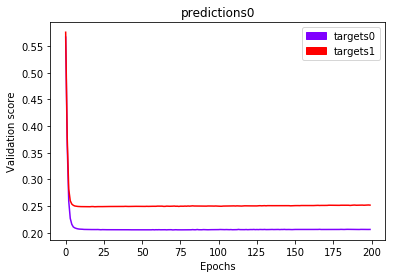

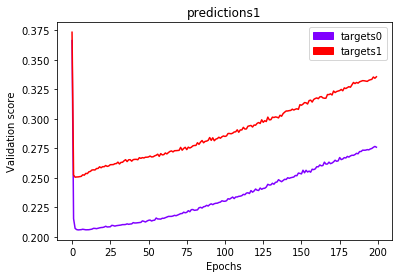

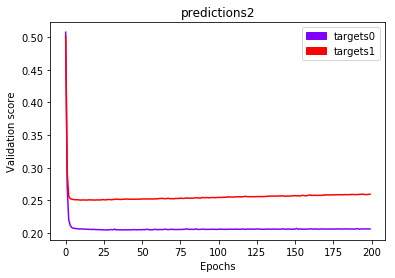

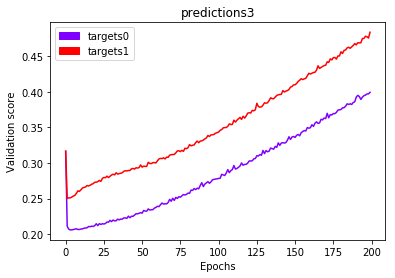

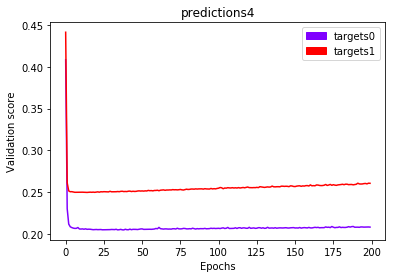

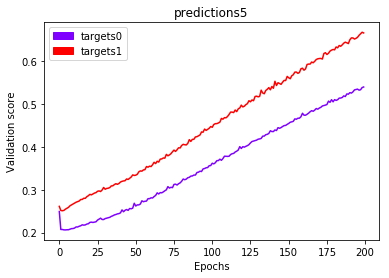

In [12]:
for i in range(n_predictors):
   
    patches = []
    title = 'predictions' + str(i)
    color = iter(cm.rainbow(np.linspace(0,1,n_targets)))
    for j in range(n_targets):
        c = next(color)
        exec(f'plt.plot(model_training{i}{j}.history[\'val_loss\'], c=c)')
        exec(f'p{i} = mpatches.Patch(color=c, label=\'targets{j}\')')
        exec(f'patches.append(p{i})')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Validation score')

    plt.legend(handles=patches)

    plt.show()

## Predict based on model

In [13]:
for i in range(n_predictors):
    for j in range(n_targets):
        exec(f'modpred{i}{j} = model{i}{j}.predict(input_test{i})')

# Plot raw output

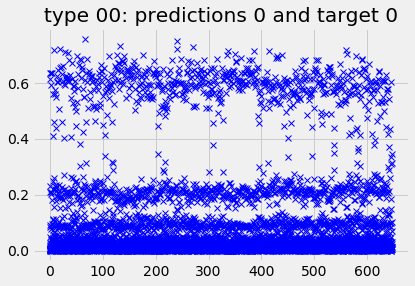

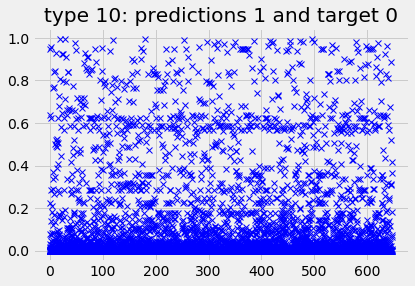

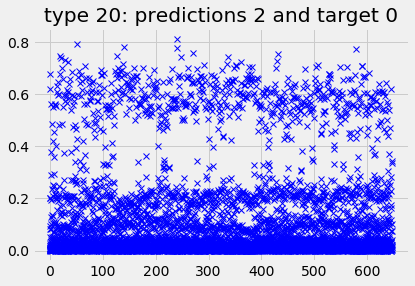

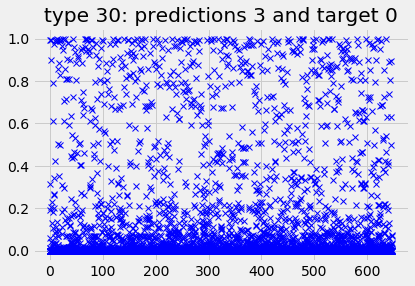

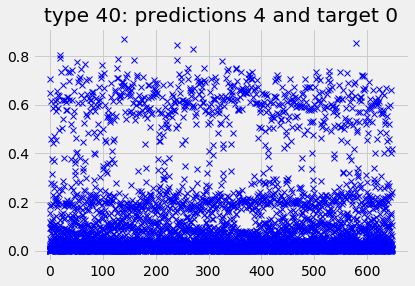

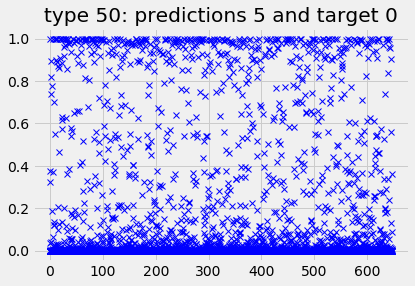

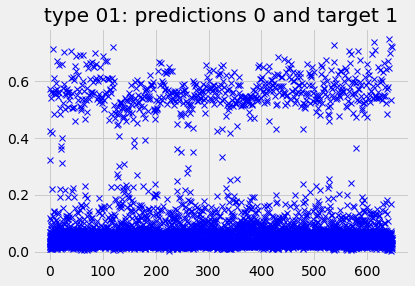

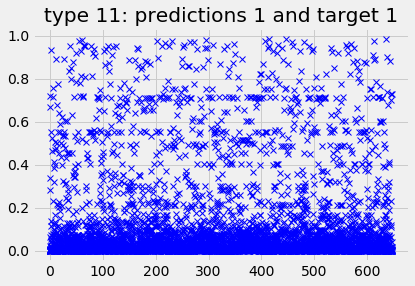

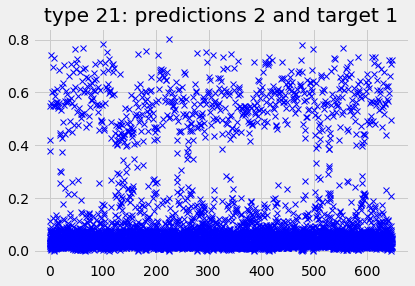

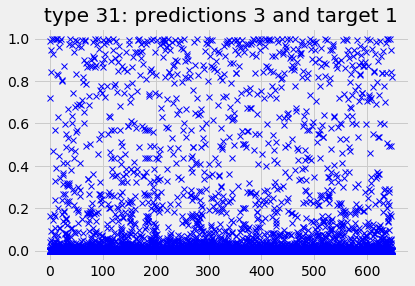

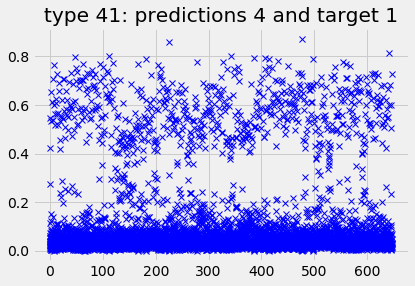

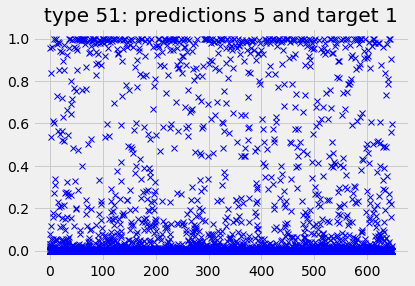

In [14]:
plt.style.use('fivethirtyeight')
types = []
n_types = 0 

for j in range(n_targets):
    for i in range(n_predictors):    
        title = 'type ' + str(i) + str(j) + ': predictions ' + str(i) + ' and target ' + str(j)
        exec(f'plt.plot(modpred{i}{j}[:],"bx")')
        types.append(title)
        plt.title(title)
        plt.show()
        n_types += 1

# Measure accuracy

## Create set based on normal distributed average

(Baseline)

In [15]:
n_dummy = 10
dummyset = []
minim = []
maxim = []
for i in range(n_targets):
    dummyset.append(ds.getGroundTruthTime(mags[i]))
    minim.append(min(dummyset[i]))
    maxim.append(max(dummyset[i]))

In [16]:
dummy = []
dummy_disc = []
len_du_disc = 0

for i in range(n_targets):
    for j in range(n_dummy):
        dummy.append(Utils.S_model_Predict(dummyset[i], enable_random_normal=True))
        dummy[len_du_disc] = dummy[len_du_disc][splitat : ]
        dummy_disc.append(Utils.getDiscr3t3(categories_out, dummy[len_du_disc], minim[i], maxim[i]))
        len_du_disc += 1

## Plot baseline prediction

In [17]:
perc_avg_list = []
perc_avg_avg = []

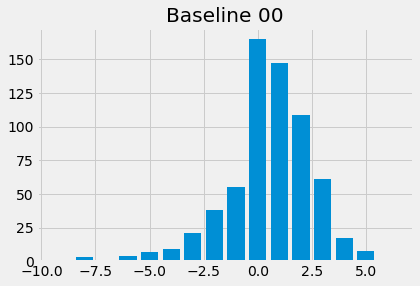

Number of correct: 165
Number of wrong: 482
Percent correct: 26%


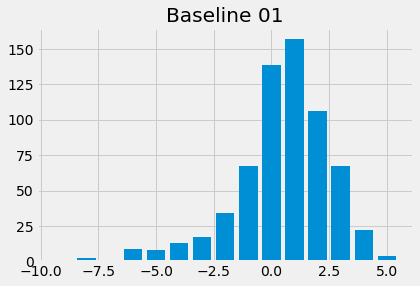

Number of correct: 139
Number of wrong: 508
Percent correct: 21%


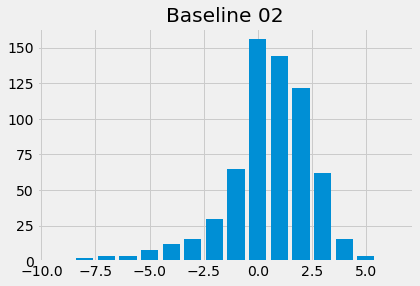

Number of correct: 156
Number of wrong: 491
Percent correct: 24%


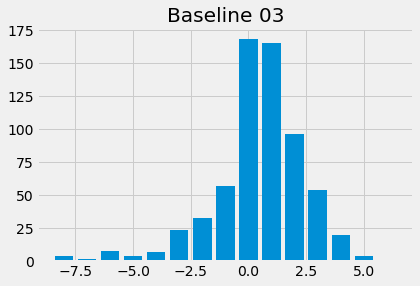

Number of correct: 168
Number of wrong: 479
Percent correct: 26%


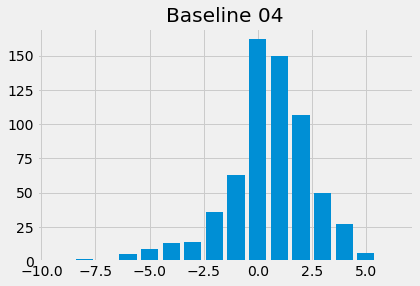

Number of correct: 162
Number of wrong: 485
Percent correct: 25%


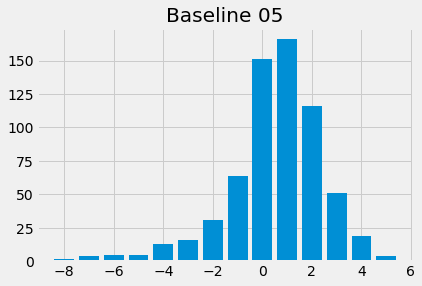

Number of correct: 151
Number of wrong: 496
Percent correct: 23%


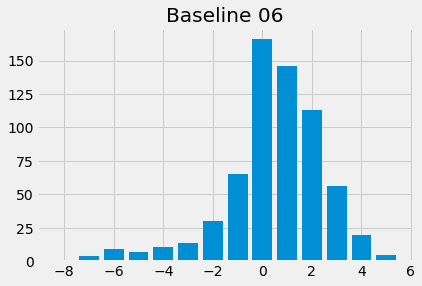

Number of correct: 166
Number of wrong: 481
Percent correct: 26%


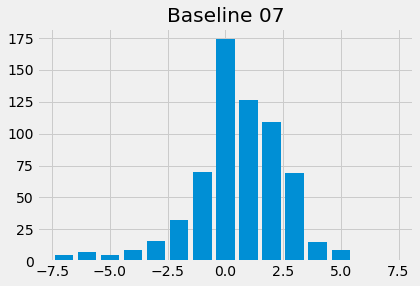

Number of correct: 174
Number of wrong: 473
Percent correct: 27%


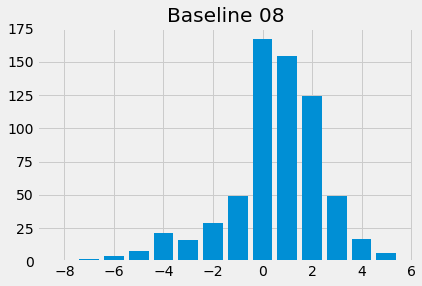

Number of correct: 167
Number of wrong: 480
Percent correct: 26%


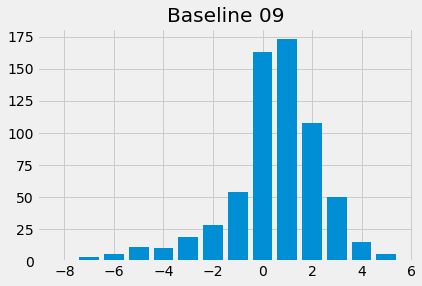

Number of correct: 163
Number of wrong: 484
Percent correct: 25%
-----------------------------------------
Average of baseline above magnitude 5.5: 25%
-----------------------------------------


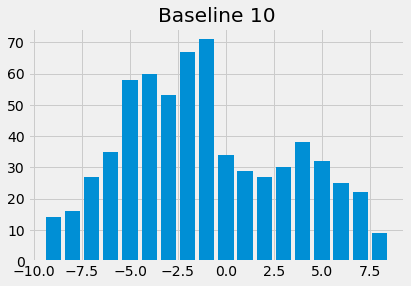

Number of correct: 34
Number of wrong: 613
Percent correct: 5%


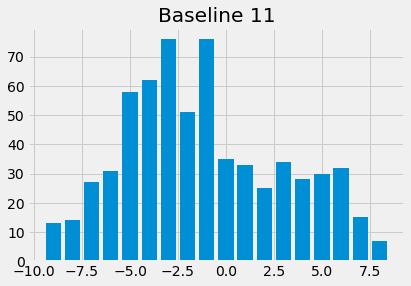

Number of correct: 35
Number of wrong: 612
Percent correct: 5%


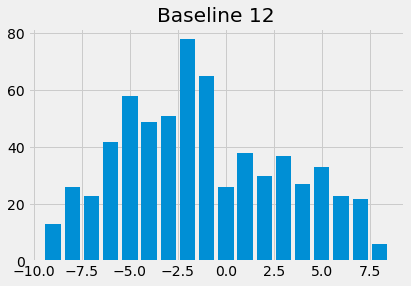

Number of correct: 26
Number of wrong: 621
Percent correct: 4%


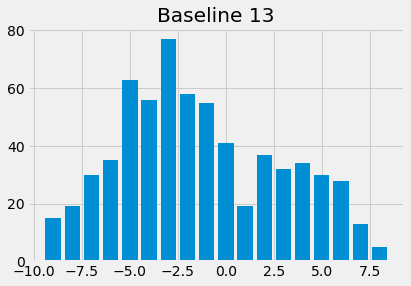

Number of correct: 41
Number of wrong: 606
Percent correct: 6%


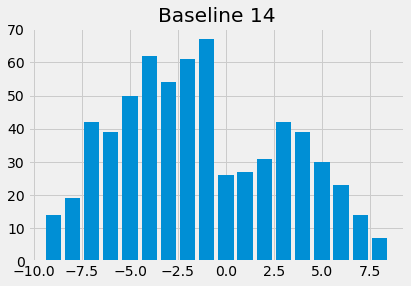

Number of correct: 26
Number of wrong: 621
Percent correct: 4%


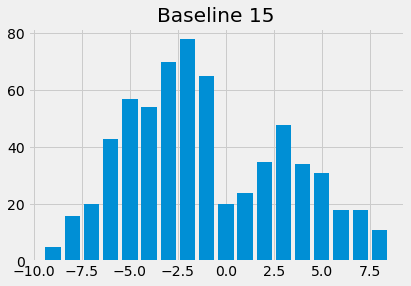

Number of correct: 20
Number of wrong: 627
Percent correct: 3%


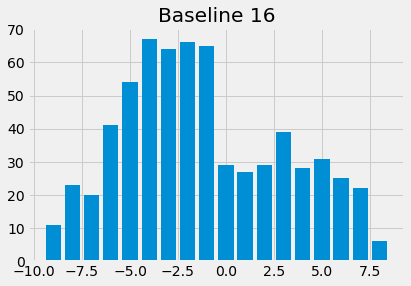

Number of correct: 29
Number of wrong: 618
Percent correct: 4%


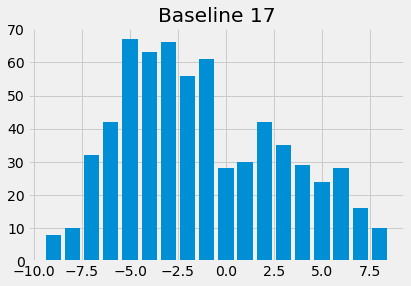

Number of correct: 28
Number of wrong: 619
Percent correct: 4%


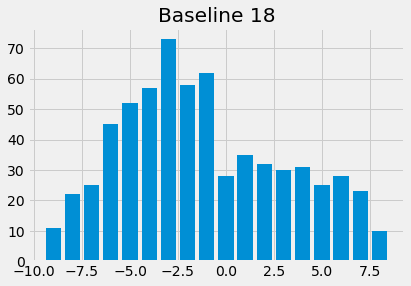

Number of correct: 28
Number of wrong: 619
Percent correct: 4%


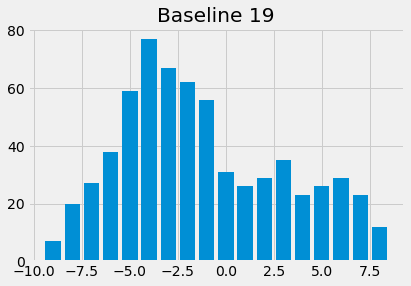

Number of correct: 31
Number of wrong: 616
Percent correct: 5%
-----------------------------------------
Average of baseline above magnitude 6.5: 4%
-----------------------------------------


In [18]:
len_du_disc = 0

for i in range(n_targets):
    perc_avg_list = []
    for j in range(n_dummy):
        plt.title('Baseline ' + str(i) + str(j))
        exec(f'perc_avg_list.append(Utils.accu_plot_disc(dummy_disc[len_du_disc], output_test{i}))')
        len_du_disc += 1
        
    perc_avg_avg.append(int(np.average(perc_avg_list).round()))
    print('-----------------------------------------')
    print('Average of baseline above magnitude ' + str(mags[i]) + ': ' + str(perc_avg_avg[i]) + '%')
    print('-----------------------------------------')

## Plot accuracy of models

In [19]:
percentage = []
n_types = 0

In [20]:
print('-----------------------------------------')
print('Plotting models:')
print('-----------------------------------------')

-----------------------------------------
Plotting models:
-----------------------------------------


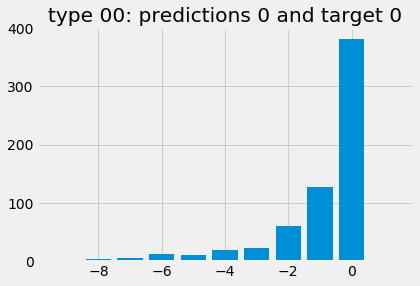

Number of correct: 381
Number of wrong: 266
Percent correct: 59%


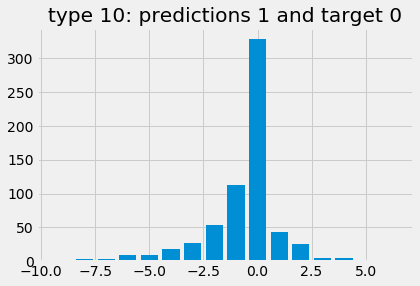

Number of correct: 328
Number of wrong: 319
Percent correct: 51%


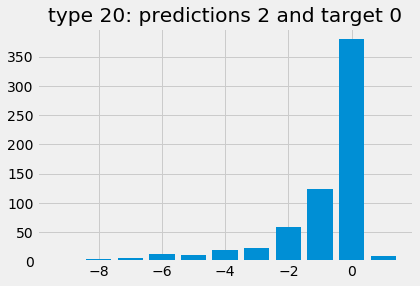

Number of correct: 380
Number of wrong: 267
Percent correct: 59%


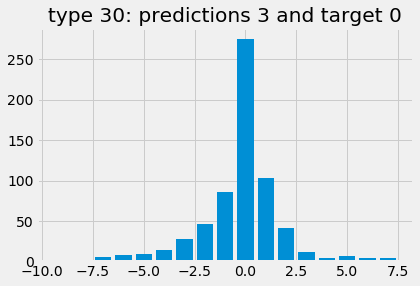

Number of correct: 275
Number of wrong: 372
Percent correct: 43%


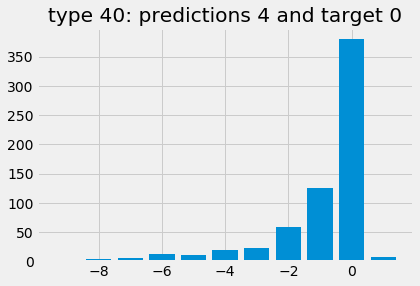

Number of correct: 380
Number of wrong: 267
Percent correct: 59%


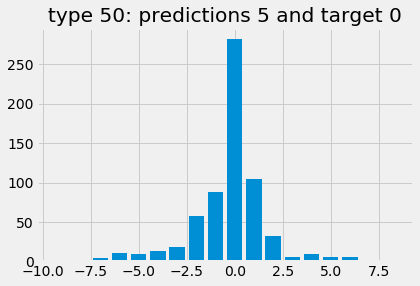

Number of correct: 282
Number of wrong: 365
Percent correct: 44%


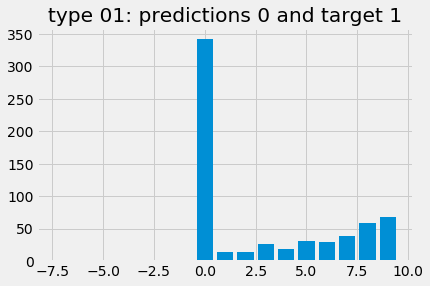

Number of correct: 342
Number of wrong: 305
Percent correct: 53%


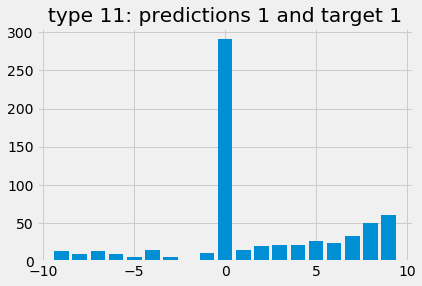

Number of correct: 291
Number of wrong: 356
Percent correct: 45%


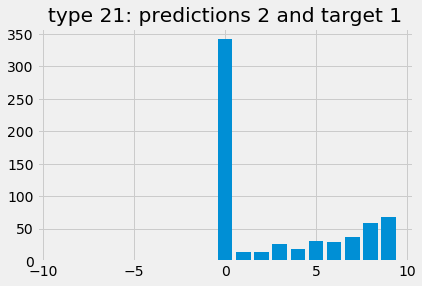

Number of correct: 342
Number of wrong: 305
Percent correct: 53%


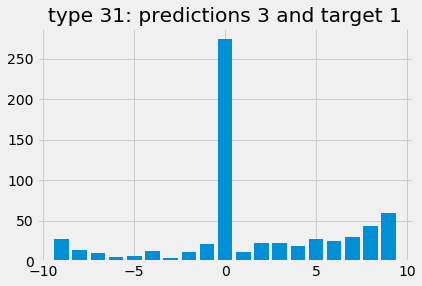

Number of correct: 274
Number of wrong: 373
Percent correct: 42%


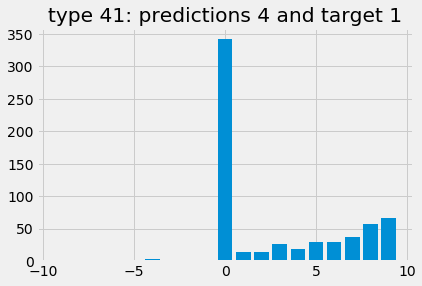

Number of correct: 342
Number of wrong: 305
Percent correct: 53%


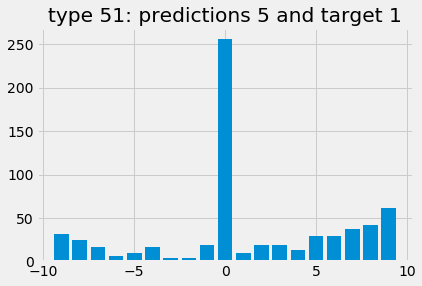

Number of correct: 256
Number of wrong: 391
Percent correct: 40%


In [21]:
for j in range(n_targets):
    for i in range(n_predictors):
        title = types[n_types]
        plt.title(title)
        exec(f'percentage.append(Utils.accu_plot_disc(modpred{i}{j}, output_test{j}))')
        n_types += 1

In [22]:
best_percentages = np.array(percentage).reshape(n_targets, n_predictors)

In [23]:
best_percentage = []
diff = []
best_pp = []
thebest = []

for i in range(n_targets):
    best_percentage.append(max(best_percentages[i]))
    diff.append(best_percentage[i] - perc_avg_avg[i])
    thebest.append(Utils.best_per_pos(best_percentages[i], best_percentage[i]))
    best_pp.append(','.join(str(n) for n in thebest[i]))
    print()
    print('Target ' + str(i))
    print('-----------------------------------------')
    print('Percentage list: ' + str(best_percentages[i]))
    print('Best percentage: ' + str(best_percentage[i]) + '%')
    print('Best performing network type (predictors): ' + str(best_pp[i]))
    print('-----------------------------------------')
    print('Baseline: Average percentage: ' + str(perc_avg_avg[i]) + '%')
    print('-----------------------------------------')
    print('Difference, baseline vs. model: ' + str(diff[i]) + '%')
    print('-----------------------------------------')



Target 0
-----------------------------------------
Percentage list: [59 51 59 43 59 44]
Best percentage: 59%
Best performing network type (predictors): 0,2,4
-----------------------------------------
Baseline: Average percentage: 25%
-----------------------------------------
Difference, baseline vs. model: 34%
-----------------------------------------

Target 1
-----------------------------------------
Percentage list: [53 45 53 42 53 40]
Best percentage: 53%
Best performing network type (predictors): 0,2,4
-----------------------------------------
Baseline: Average percentage: 4%
-----------------------------------------
Difference, baseline vs. model: 49%
-----------------------------------------


In [ ]:
print('-----------------------------------------')
print('Types:')
print('-----------------------------------------')
for line in types:
    print(line)
print('-----------------------------------------')
print('Predictors:')
print('-----------------------------------------')
for line in predict_txt:
    print(line)
print('-----------------------------------------')
print('Targets:')
print('-----------------------------------------')
for line in target_txt:
    print(line)

-----------------------------------------
Types:
-----------------------------------------
type 00: predictions 0 and target 0
type 10: predictions 1 and target 0
type 20: predictions 2 and target 0
type 30: predictions 3 and target 0
type 40: predictions 4 and target 0
type 50: predictions 5 and target 0
type 01: predictions 0 and target 1
type 11: predictions 1 and target 1
type 21: predictions 2 and target 1
type 31: predictions 3 and target 1
type 41: predictions 4 and target 1
type 51: predictions 5 and target 1
-----------------------------------------
Predictors:
-----------------------------------------
Data config 0: predictors0 - input values between -1 and 1
Data config 0: predictors1 - discrete input values (10 categories)
Data config 1: predictors2 - input values between -1 and 1
Data config 1: predictors3 - discrete input values (10 categories)
Data config 2: predictors4 - input values between -1 and 1
Data config 2: predictors5 - discrete input values (10 categories)
---

# Backup the notebook

In [ ]:
a = input("Press enter to backup the notebook (save first)")

In [ ]:
path = './output/' + current_file + '/'

In [ ]:
epochs = str(epochs) + early
perc_t = np.array(percentage).reshape(n_targets, n_predictors)
best_max = max(best_percentage)

In [ ]:
output_file = Utils.join_list([current_file, activation, maxdays, epochs, best_max], '-')

In [ ]:
type_perc = []
infolist = []
for i in range(n_targets):
    type_perc.append(Utils.join_list(perc_t[i], '|'))
    infolist.append([i, best_percentage[i], perc_avg_avg[i], diff[i], best_pp[i], activation, maxdays,
                     epochs, categories_out, type_perc[i]])

out_org0 = Utils.org_table([infolist[0]])
out_org1 = Utils.org_table([infolist[1]])

In [ ]:
print(out_org0)

In [ ]:
print(out_org1)

In [ ]:
%%bash -s "$current_file" "$path" "$output_file" "$out_org0" "$out_org1"
jupyter nbconvert --to html $1.ipynb
mv $1.html $2$(date +"%Y%m%d-%H%M%S")-$3.html
jupyter nbconvert --to latex $1.ipynb
mv $1.tex $2backup/$(date +"%Y%m%d-%H%M%S")-$3.tex
mv $1_files $2backup/$(date +"%Y%m%d-%H%M%S")-$3
cp $1.ipynb $2backup/notebook/$(date +"%Y%m%d-%H%M%S")-$3.ipynb
echo $4 >> $2info0.org
echo $5 >> $2info1.org